Fetch MNIST dataset to /data

In [41]:
import kagglehub
import os
import shutil

data_dir = os.path.join(os.getcwd(), "data")
os.makedirs(data_dir, exist_ok=True)

cache_path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Cache path:", cache_path)

for file in os.listdir(cache_path):
    src_file = os.path.join(cache_path, file)
    dst_file = os.path.join(data_dir, file)
    
    if os.path.isfile(src_file):
        shutil.copy2(src_file, dst_file)
        print(f"Copied {file} to {data_dir}")

print(f"All dataset files copied to {data_dir}")

Cache path: /Users/thehamcar/.cache/kagglehub/datasets/hojjatk/mnist-dataset/versions/1
Copied train-labels.idx1-ubyte to /Users/thehamcar/MNIST MLP/data
Copied train-images.idx3-ubyte to /Users/thehamcar/MNIST MLP/data
Copied t10k-labels.idx1-ubyte to /Users/thehamcar/MNIST MLP/data
Copied t10k-images.idx3-ubyte to /Users/thehamcar/MNIST MLP/data
All dataset files copied to /Users/thehamcar/MNIST MLP/data


Create function to read the ubyte images and labels
Structure of the files in binary: 

Header structure (first 16 bytes):

Bytes 0-3: Magic number (2051) indicating this is an image file
Bytes 4-7: Number of images in the file
Bytes 8-11: Number of rows per image (28)
Bytes 12-15: Number of columns per image (28)

Consecutive  28x28 (784) bytes representing each image

Header structure (first 8 bytes):

Bytes 0-3: Magic number (2049) indicating this is a label file
Bytes 4-7: Number of labels in the file

Consecutive single bytes from 0-9

In [42]:
import numpy as np

def load_mnist_images(filename):
    with open(filename, 'rb') as f:
        #f.read moves the pointer as it reads
        magic = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        images = np.frombuffer(f.read(), dtype=np.uint8)
        images = images.reshape((num_images, num_rows, num_cols))
        return images

def load_mnist_labels(filename):
    with open(filename, 'rb') as f:
        magic = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        return labels
    
def display_image(image, label):
    import matplotlib.pyplot as plt
    plt.imshow(image, cmap='gray')
    plt.title(f'Label: {label}')
    plt.axis('off')
    plt.show()

Load MNIST dataset

In [43]:
X_train = load_mnist_images(os.path.join(data_dir, "train-images.idx3-ubyte"))
y_train = load_mnist_labels(os.path.join(data_dir, "train-labels.idx1-ubyte"))
X_test = load_mnist_images(os.path.join(data_dir, "t10k-images.idx3-ubyte"))
y_test = load_mnist_labels(os.path.join(data_dir, "t10k-labels.idx1-ubyte"))
print("Loaded MNIST dataset")

Loaded MNIST dataset


Initialise parameters

In [44]:
input_size = 784  #28x28 pixel images
hidden_size = 128  #Number of hidden neurons
output_size = 10  # Number of classes

# Initialize weights and biases
np.random.seed(6969)  # For reproducibility
weights_input_hidden = np.random.randn(input_size, hidden_size) * 0.01
bias_hidden = np.zeros((1, hidden_size))
weights_hidden_output = np.random.randn(hidden_size, output_size) * 0.01
bias_output = np.zeros((1, output_size))

print("Parameters initialized")

Parameters initialized


define forward passing

In [45]:
def relu(x):
    return np.maximum(0, x)
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [46]:
def forward_pass(X, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output):
    #Flatten the input images
    X_flattened = X.reshape(X.shape[0], -1)  #Reshape to (num_samples, input_size)
    
    #Input to hidden layer
    hidden_input = np.dot(X_flattened, weights_input_hidden) + bias_hidden
    hidden_output = relu(hidden_input)  #Apply ReLU activation
    
    #Hidden to output layer
    output_input = np.dot(hidden_output, weights_hidden_output) + bias_output
    output = softmax(output_input)  # Apply softmax activation for output layer
    
    return output

In [47]:
def cross_entropy_loss(predictions, labels):
    #Clip predictions to avoid log(0)
    predictions = np.clip(predictions, 1e-12, 1.0)
    #Compute cross-entropy loss
    loss = -np.sum(labels * np.log(predictions)) / labels.shape[0]
    return loss

In [48]:
def relu_derivative(x):
    return (x > 0).astype(float)

def backward_pass(X, y, output, weights_input_hidden, bias_hidden, weights_hidden_output, bias_output, learning_rate=0.01):
    # One-hot encode the labels
    y_one_hot = np.zeros((y.size, output_size))
    y_one_hot[np.arange(y.size), y] = 1

    # Compute the error at the output layer
    output_error = output - y_one_hot  # Shape: (num_samples, output_size)

    # Compute gradients for weights_hidden_output and bias_output
    hidden_output = relu(np.dot(X.reshape(X.shape[0], -1), weights_input_hidden) + bias_hidden)
    grad_weights_hidden_output = np.dot(hidden_output.T, output_error) / X.shape[0]
    grad_bias_output = np.sum(output_error, axis=0, keepdims=True) / X.shape[0]

    # Backpropagate the error to the hidden layer
    hidden_error = np.dot(output_error, weights_hidden_output.T) * relu_derivative(hidden_output)

    # Compute gradients for weights_input_hidden and bias_hidden
    grad_weights_input_hidden = np.dot(X.reshape(X.shape[0], -1).T, hidden_error) / X.shape[0]
    grad_bias_hidden = np.sum(hidden_error, axis=0, keepdims=True) / X.shape[0]

    # Update weights and biases
    weights_hidden_output -= learning_rate * grad_weights_hidden_output
    bias_output -= learning_rate * grad_bias_output
    weights_input_hidden -= learning_rate * grad_weights_input_hidden
    bias_hidden -= learning_rate * grad_bias_hidden

    return weights_input_hidden, bias_hidden, weights_hidden_output, bias_output

In [49]:
def train(X_train, y_train, epochs=10, batch_size=100, learning_rate=0.01):
    # Use global to access these variables defined outside the function
    global weights_input_hidden, bias_hidden, weights_hidden_output, bias_output
    
    # Track loss history
    loss_history = []
    
    for epoch in range(epochs):
        # Shuffle the training data
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        total_loss = 0
        
        # Process in mini-batches
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward pass
            output = forward_pass(X_batch, weights_input_hidden, bias_hidden, 
                                 weights_hidden_output, bias_output)
            
            # Compute loss
            y_one_hot = np.zeros((y_batch.size, output_size))
            y_one_hot[np.arange(y_batch.size), y_batch] = 1
            batch_loss = cross_entropy_loss(output, y_one_hot)
            total_loss += batch_loss * len(X_batch)
            
            # Backward pass
            weights_input_hidden, bias_hidden, weights_hidden_output, bias_output = backward_pass(
                X_batch, y_batch, output, weights_input_hidden, bias_hidden, 
                weights_hidden_output, bias_output, learning_rate
            )
        
        # Calculate average loss for the epoch
        avg_loss = total_loss / len(X_train)
        loss_history.append(avg_loss)
        
        # Print progress
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return loss_history

In [50]:
def evaluate(X, y):
    # Forward pass
    predictions = forward_pass(X, weights_input_hidden, bias_hidden, 
                              weights_hidden_output, bias_output)
    
    # Get predicted classes
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    accuracy = np.mean(predicted_classes == y)
    return accuracy

In [ ]:
# Run training
epochs = 100
batch_size = 128
learning_rate = 0.01

loss_history = train(X_train, y_train, epochs, batch_size, learning_rate)

Epoch 1/100, Loss: 1.5214
Epoch 2/100, Loss: 1.4833
Epoch 3/100, Loss: 1.5000
Epoch 4/100, Loss: 1.4866
Epoch 5/100, Loss: 1.4811
Epoch 6/100, Loss: 1.4847
Epoch 7/100, Loss: 1.4744
Epoch 8/100, Loss: 1.7233
Epoch 9/100, Loss: 1.7792


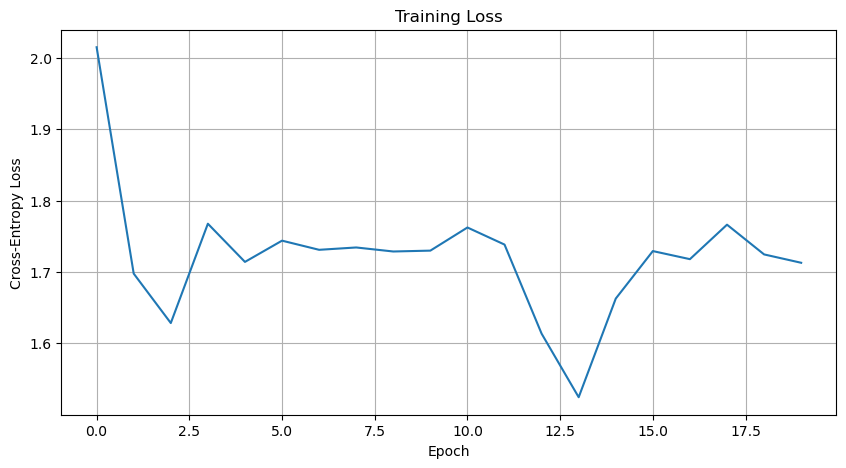

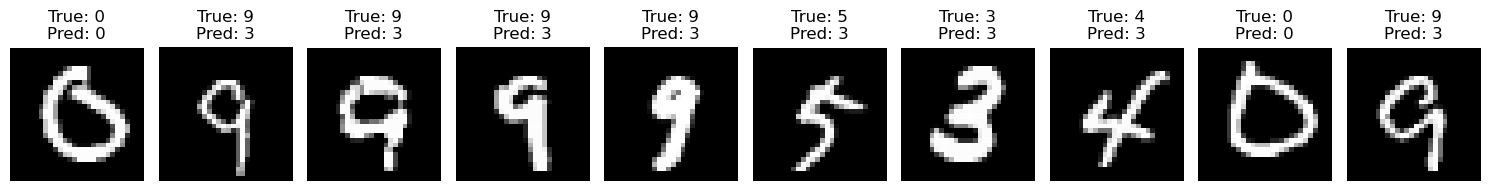

In [ ]:
# Plot loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True)
plt.show()

# Visualize some predictions
def visualize_predictions(num_samples=10):
    # Get random test examples
    indices = np.random.choice(len(X_test), num_samples)
    
    # Get predictions
    test_images = X_test[indices]
    test_labels = y_test[indices]
    predictions = forward_pass(test_images, weights_input_hidden, bias_hidden, 
                              weights_hidden_output, bias_output)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Plot
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(test_images[i], cmap='gray')
        axes[i].set_title(f"True: {test_labels[i]}\nPred: {predicted_classes[i]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions()

In [ ]:
evaluate_accuracy = evaluate(X_test, y_test)
print(f"Test Accuracy: {evaluate_accuracy:.4f}")


Test Accuracy: 0.3935
